# Empty environment

In this notebook, we showcase the whole pipeline of 

1) defining the navground scenario
2) creating the Gymnasium enviroment
3) training a policy
4) evaluating in the policy
5) saving the policy
6) using the policy in navground

in a very simple navigation task where a single agent has to move towards a target direction in an empty space, which therefore require no additional sensing information.

Steps 1 and 6 play in navground, while steps 2--5 in Gymnasium.

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Defining a scenario

In [2]:
from navground import sim

duration = 2.0
time_step = 0.1
scenario = sim.load_scenario("""
bounding_box:
  min_x: -1
  max_x: 3
  min_y: -1
  max_y: 1
groups:
  -
    type: thymio
    number: 1
    radius: 0.5
    control_period: 0.1
    color: blue
    kinematics:
      type: 2WDiff
      wheel_axis: 1
      max_speed: 1
    behavior:
      type: Dummy
    task:
      type: Direction
      direction: [1, 0]
    orientation:
      sampler: uniform
      from: 0
      to: 6.28
""")

In this scenario, the robot starts at a random orientation and then move rightwards.
As there are no obstacles to avoid, the dummy behavior performs just fine.

In [3]:
from navground.sim.ui.video import display_video

world = scenario.make_world(seed=0)
display_video(world, time_step=time_step, duration=duration, display_width=300)

## Creating an enviroment

In [4]:
import gymnasium as gym
from navground.learning import ControlActionConfig, DefaultObservationConfig
from navground.learning.rewards import EfficacyReward
import navground.learning.env

env = gym.make('navground',
    scenario=scenario,
    action=ControlActionConfig(),
    observation=DefaultObservationConfig(flat=True, include_target_direction=True),
    reward=EfficacyReward(),
    time_step=time_step,
    max_duration=duration)

The enviroment is configured to use velocity actions (linear and angular components) normalized in `[-1, 1]`

In [5]:
env.action_space

Box(-1.0, 1.0, (2,), float32)

and observations which just contains the relative target direction (as unit vector)

In [6]:
env.observation_space

Box(-1.0, 1.0, (2,), float32)

## Training policies

### Imitation Learning

We train a policy using Behavior Cloning, imitating the dummy (expert) behavior 

In [7]:
from navground.learning.il import BC, setup_tqdm

setup_tqdm()

bc = BC(env=env, policy_kwargs={'net_arch': [8, 8]})
bc.collect_runs(1_000)
bc.learn(n_epochs=8, progress_bar=True)
bc.save("BC/model")

0batch [00:00, ?batch/s]

### Reinforcement Learning

We train a policy using SAC for 20000 steps, which is the same as 1000 runs.

In [8]:
from stable_baselines3 import SAC

sac = SAC("MlpPolicy", env, verbose=0, policy_kwargs={'net_arch': [8, 8]})
sac.learn(total_timesteps=20_000, progress_bar=True)
sac.save("SAC/model")

Output()

## Evaluating the policies

The maximal efficacy is 1, therefore the maximal cumulated reward is `duration / time_step * 1`

In [9]:
# Equivalent to 
# from stable_baselines3.common.evaluation import evaluate_policy

# but supports model using the info dict for prediction
from navground.learning.evaluation import evaluate_policy

# we could also run
# from navground.learning.evaluation import evaluate
# expert_reward_mean, expert_reward_std_dev = evaluate(env, n_eval_episodes=1_000)

max_reward = duration / time_step
expert_reward_mean, expert_reward_std_dev = evaluate_policy(env.unwrapped.policy, env, n_eval_episodes=1_000)
expert_reward_mean  /= max_reward
expert_reward_std_dev /= max_reward
print(f"Dummy:\treward = {expert_reward_mean:.1%} ± {expert_reward_std_dev:.1%}")

Dummy:	reward = 54.9% ± 25.9%


The policies perform similarly to the expert

In [10]:
from stable_baselines3.common.env_util import make_vec_env

# uses random seed
test_env = make_vec_env('navground', env_kwargs=env.spec.kwargs)

for model in (bc, sac):
    reward_mean, reward_std_dev = evaluate_policy(model.policy, test_env, n_eval_episodes=1_000)
    reward_mean  /= max_reward
    reward_std_dev /= max_reward
    name = model.__class__.__name__
    print(f"{name}:\treward = {reward_mean:.1%} ± {reward_std_dev:.1%}")

BC:	reward = 60.3% ± 22.9%
SAC:	reward = 57.5% ± 23.6%


Let's also check which mapping between target direction and velocity commands has been learned.
Let's start by computing the expert's mapping:

In [11]:
from navground import core
import numpy as np

world = scenario.make_world()
world._prepare()
behavior = world.agents[0].behavior
angles = np.linspace(0, 2 * np.pi, 360)
dirs = np.array([core.unit(a) for a in angles])
expert_cmds = []
for angle in angles:
    behavior.orientation = -angle
    cmd = behavior.compute_cmd(0.1)
    expert_cmds.append([cmd.velocity[0], cmd.angular_speed])
expert_cmds = np.asarray(expert_cmds)

Then we can evaluate the policies

In [12]:
def get_cmds(model):
    cmds, _ = model.policy.predict(dirs)
    cmds[:, 0] *= behavior.max_speed
    cmds[:, 1] *= behavior.max_angular_speed
    return cmds

bc_cmds = get_cmds(bc)
sac_cmds = get_cmds(sac)

and compare them

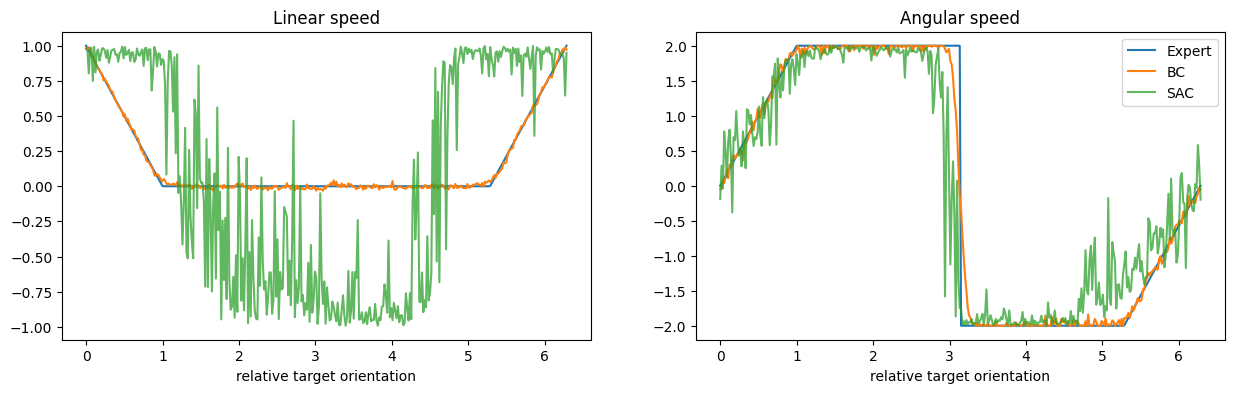

In [13]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

for i, (ax, name) in enumerate(zip(axs, ('Linear', 'Angular'))):
    ax.plot(angles, expert_cmds[:, i], label="Expert")
    ax.plot(angles, bc_cmds[:, i], label="BC")
    ax.plot(angles, sac_cmds[:, i], label="SAC", alpha=0.75)
    ax.set_xlabel("relative target orientation")
    ax.set_title(f'{name} speed')

plt.legend()

We note that the SAC outputs very noisy linear speeds. This happens because the commands outputted by the policy, before being actuated, are filtered by the kinematics of the agents, which return the nearest feasible command. In this case, for large enough angular speeds, the kinematics nullifies the linear components to respect the constrains due to the limited  wheel speeds. Basically, in this case, it would be enough to learn to control angular speed, and keep linear speed maximal. 

After we compute feasible commands

In [14]:
kinematics = world.agents[0].kinematics

def get_feasible_cmds(model):
    cmds, _ = model.policy.predict(dirs)
    twists = [kinematics.feasible(core.Twist2((cmd[0] * behavior.max_speed, 0), cmd[1] * behavior.max_angular_speed)) for cmd in cmds]
    return np.asarray([[twist.velocity[0], twist.angular_speed] for twist in twists])

bc_feasible_cmds = get_feasible_cmds(bc)
sac_feasible_cmds = get_feasible_cmds(sac)

the plots are more interpretable, altough the SAC policy remains more noisy

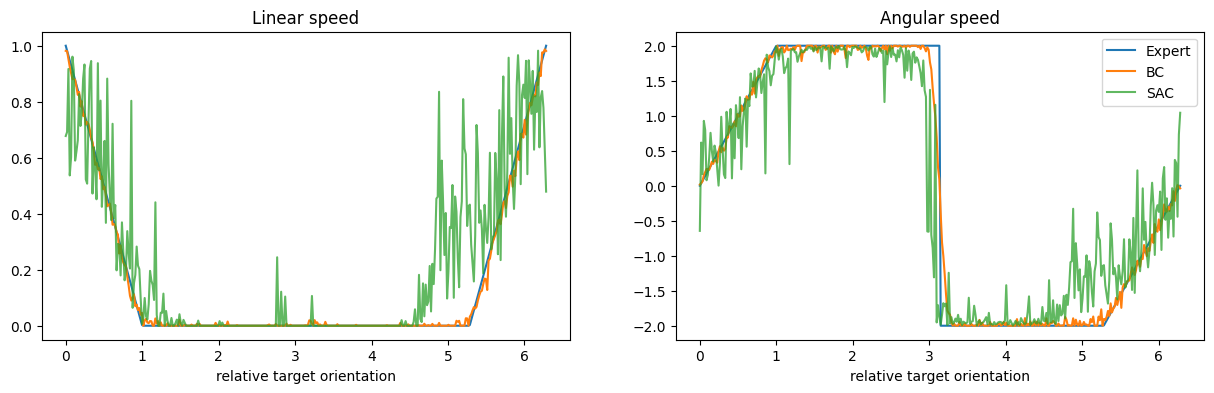

In [15]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

for i, (ax, name) in enumerate(zip(axs, ('Linear', 'Angular'))):
    ax.plot(angles, expert_cmds[:, i], label="Expert")
    ax.plot(angles, bc_feasible_cmds[:, i], label="BC")
    ax.plot(angles, sac_feasible_cmds[:, i], label="SAC", alpha=0.75)
    ax.set_xlabel("relative target orientation")
    ax.set_title(f'{name} speed')

plt.legend()

## Exporting the trained policy

We have already saved the trained models, which we can later reload with

```python
from navground.learning.il import BC
from stable_baselines3 import SAC

bc = BC.load("BC.zip")
sac = SAC.load("SAC.zip")
```

We now export to onnx, along with YAML files describing the behavior and sensor (if any) to use them.

In [16]:
from navground.learning import io

for model in (bc, sac):
    name = model.__class__.__name__
    io.export_policy_as_behavior(path=name, env=env, policy=model.policy)

In [17]:
ls BC

behavior.yaml  model.zip      policy.onnx


## Using the policies in navground

For inference, we can either use the trained PyTorch policy direcly or load the onnx version

In [18]:
from navground.learning import onnx

policy = onnx.OnnxPolicy("SAC/policy.onnx")

They produce the same outputs 

In [19]:
obs = env.observation_space.sample() 

policy.predict(obs), bc.policy.predict(obs, deterministic=True)

((array([0.88362646, 0.08671234], dtype=float32), None),
 (array([0.4916103 , 0.51834273], dtype=float32), None))

but the onnx version does it faster

In [20]:
%%timeit 

policy.predict(obs)

5.81 μs ± 64.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [21]:
%%timeit 

bc.policy.predict(obs, deterministic=True)

60.9 μs ± 79.7 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


To use them in navground, we assign a PolicyBehavior to the agent

In [22]:
from navground.learning.behaviors import PolicyBehavior

world = scenario.make_world(seed=0)
world.agents[0].behavior = PolicyBehavior(
    policy=onnx.OnnxPolicy("BC/policy.onnx"), 
    action_config=env.unwrapped.action_config, 
    observation_config=env.unwrapped.observation_config)
world.agents[0].color = 'orange'

display_video(world, time_step=time_step, duration= 2 * duration, display_width=300)

In [23]:
world = scenario.make_world(seed=0)
world.agents[0].behavior = PolicyBehavior(
    policy=policy, 
    action_config=env.unwrapped.action_config, 
    observation_config=env.unwrapped.observation_config)
world.agents[0].color = 'green'

display_video(world, time_step=time_step, duration= 2 * duration, display_width=300)

As usual in navground, we may prefer to confugure the scenario from YAML, like for the following experiment, where we alternate runs with one agent controlled by `Dummy`, one by the policy learned by `BC` and one by the policy learned by `SAC`.

In [24]:
experiment = sim.load_experiment("""
steps: 20
time_step: 0.1
record_efficacy: true
runs: 3000
scenario:
  bounding_box:
    min_x: -1
    max_x: 5
    min_y: -1
    max_y: 1
  groups:
    -
      type: thymio
      number: 
        sampler: sequence
        values: [1, 0, 0]
        once: true
      radius: 0.5
      control_period: 0.1
      color: blue
      kinematics:
        type: 2WDiff
        wheel_axis: 1
        max_speed: 1
      color: blue
      behavior:
        type: Dummy
      task:
        type: Direction
        direction: [1, 0]
      orientation:
        sampler: uniform
        from: 0
        to: 6.28
    -
      type: thymio
      number: 
        sampler: sequence
        values: [0, 1, 0]
        once: true
      radius: 0.5
      control_period: 0.1
      color: blue
      kinematics:
        type: 2WDiff
        wheel_axis: 1
        max_speed: 1
      color: blue
      behavior:
        type: Policy
        policy_path: BC/policy.onnx
        include_target_direction: true
        flat: true
      task:
        type: Direction
        direction: [1, 0]
      orientation:
        sampler: uniform
        from: 0
        to: 6.28
    -
      type: thymio
      number: 
        sampler: sequence
        values: [0, 0, 1]
        once: true
      radius: 0.5
      control_period: 0.1
      color: blue
      kinematics:
        type: 2WDiff
        wheel_axis: 1
        max_speed: 1
      color: blue
      behavior:
        type: Policy
        policy_path: SAC/policy.onnx
        include_target_direction: true
        flat: true
      task:
        type: Direction
        direction: [1, 0]
      orientation:
        sampler: uniform
        from: 0
        to: 6.28
""")

experiment.run()

In [25]:
experiment.duration

datetime.timedelta(seconds=2, microseconds=104335)

In [26]:
efficacy = np.stack([run.efficacy for run in experiment.runs.values()], axis=0)

expert_efficacy = efficacy[::3]
bc_efficacy = efficacy[1::3]
sac_efficacy = efficacy[2::3]

In [27]:
print(f"Expert: efficacy = {expert_efficacy.mean():.1%} ± {expert_efficacy.std():.1%}")
print(f"BC: efficacy = {bc_efficacy.mean():.1%} ± {bc_efficacy.std():.1%}")
print(f"SAC: efficacy = {sac_efficacy.mean():.1%} ± {sac_efficacy.std():.1%}")

Expert: efficacy = 56.1% ± 39.5%
BC: efficacy = 54.9% ± 39.4%
SAC: efficacy = 54.3% ± 37.4%


which, as expected, are similar to the values sampled earlier in using `evalute_policy` , yet now computed inside of navground. 